<a href="https://colab.research.google.com/github/minsmis/NaverAI/blob/main/notebooks/2%EC%A3%BC/13%EC%B0%A8%EC%8B%9C/1_%EC%BD%94%EB%93%9C_%EC%97%85%EA%B7%B8%EB%A0%88%EC%9D%B4%EB%93%9C_%EC%86%8C%EA%B0%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [코드리뷰 프로젝트] 1. 코드 업그레이드

✔︎ 이번 프로젝트의 진행방식은 다음과 같습니다 :
- '코드리뷰 프로젝트'는 코치의 1:1 피드백이 진행되는 프로젝트입니다.
- 첨부된 파일에 안내된 절차에 따라 최소 10줄 이상의 긴 코드를 작성함으로 미션을 수행합니다.
- 작성할 코드 구간은 ## 코드시작 ## 부터 ## 코드종료 ## 구간입니다. 원활한 코드리뷰를 위해 나머지 명시되지 않은 구간은 임의로 수정하지 마세요!
- 프로젝트 제출시, 담당코치가 훈련생 분의 학습현황을 파악하고 리뷰를 진행합니다. (영업일 기준 7일 이내)


✔︎ 프로젝트 수행에 어려움을 겪고 있다면?
- 만약 프로젝트 수행에 어려움을 겪고 있거나 제출을 끝냈다면, 코치 1:1 문의를 통해 예시 정답을 요청해 보세요.
- 웍스와 자유게시판을 통해 다른 훈련생들과 문제점을 공유하고 해결방안을 도모하는 것도 좋은 방법입니다.


## 0. 전처리 & 모델 학습

**본 프로젝트는 ' [셀프리뷰 프로젝트] 4. 캐글 제출 ' 과 연결되어 있습니다.**

미션에 대한 이해도를 높이기 위해 앞선 프로젝트를 먼저 수행하신 후, 진행하시는 걸 권장해 드립니다.

In [1]:
# 데이터 다운로드
# !wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip

# 데이터 다운로드: Changed for jupyter in pycharm.
import wget

url = 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0'
filename = wget.download(url, 'kaggle-kakr-housing-data.zip')
print(filename)

kaggle-kakr-housing-data.zip


In [2]:
# 다운로드 받은 zip파일 압축풀기
# !unzip -qq ./kaggle-kakr-housing-data.zip

# 다운로드 받은 zip파일 압축풀기
import zipfile

targetdir = './'
with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(targetdir)

지난 번에 작성한 전처리 & 모델 학습 코드를 실행합니다.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#--------------------------------------------------------------------------------------------------------------------------------------
train_data_path = join('./data/train.csv')
sub_data_path = join('./data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

#--------------------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

#--------------------------------------------------------------------------------------------------------------------------------------
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

#--------------------------------------------------------------------------------------------------------------------------------------
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

#--------------------------------------------------------------------------------------------------------------------------------------
y_log_transformation = np.log1p(y)

sub = data.iloc[train_len:, :] # 테스트 데이터
x = data.iloc[:train_len, :] # 학습 데이터

print(x.shape)
print(sub.shape)


(15035, 19)
(6468, 19)


In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------
gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

#--------------------------------------------------------------------------------------------------------------------------------------
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)


In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------
def AveragingBlending(models, x, y, sub_x):
    # 모델학습
    for m in models :
        m['model'].fit(x.values, y)

    # 모델예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])

    # 각 모델 에측의 평균을 return
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

## 1. 하이퍼 파라미터 튜닝

- 모델 성능을 평가하기 위한 지표를 구현합니다.
- 더 높은 성능을 가진 머신러닝 모델을 만들기 위해 하이퍼 파라미터를 활용합니다.
- 튜닝한 결과를 모델에 저장하고, 학습 후 예측 결과를 생성합니다.

이제부터는 제공된 베이스라인 모델이 아닌 우리 스스로 모델을 만들어 보도록 하겠습니다. 일단 베이스라인에서 모델 학습을 진행하였고 전처리도 진행하였기 때문에 이는 그대로 가보려고 합니다.

`price`인 `y`는 지난번 살펴본 것처럼 그 분포가 왼쪽으로 크게 치우져 있었기 때문에 [`np.log1p()`](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html) 함수를 이용하여 로그변환을 해주고 모델 에측이 끝났을 때 그 역함수인 [`np.expm1()`](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html)을 이용하여 돌려 놓겠습니다.

In [ ]:
train = x # 기존 학습 데이터를 train으로
test = sub # 기존 테스트 데이터를 test로
y = np.log1p(y) # y값(price)의 로그변환

### 1_ RMSE 계산함수 만들기

RMSE를 계산하는 함수를 만들어 보겠습니다. `sklearn` 패키지를 활용할 것 입니다. 먼저 [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)과 [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)를 가져옵니다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

한 가지 주의해야 할 것은 아래의 `y_test`나 `y_pred`는 위에서 `np.log1p()`로 변환된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 `np.expm1()`을 추가해야 한다는 점 입니다.
따라서 RMSE를 구하는 함수는 다음과 같습니다.

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

다음으로 `XGBRegressor`, `LGBMRegressor`,`GradientBoostingRegressor`, `RandomForestRegressor` 네 가지 모델을 가져오겠습니다.

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

아래와 같이 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.

In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
# random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state=2023        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

이때, 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나 지정하지 않고 None으로 세팅할 수 있습니다. random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현됩니다. 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라집니다.

앞으로 우리는 베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증해 보려고 합니다. 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 합니다. 따라서 아래와 같이 random_state 값을 특정 값으로 고정시킬 것입니다.

### 2_ 스코어를 출력하는 함수 만들기

아래의 코드는 위에서 만들어둔 모델을 순환하면서 그 결과를 `score_df`라는 DataFrame으로 반환하는 함수입니다. `get_score`함수이고 함수 파라미터로 다음을 받습니다.

`def get_scores(models, train, y)`
- `models` : model을 가지고 있는 list
- `train` : 학습 데이터 (함수 내부에서 validation 데이터로도 나뉨)
- `y` : 학습할 때 사용할 정답 레이블 데이터

In [ ]:
def get_scores(models, train, y):
    df = {} # 결과 저장을 위한 table 생성
    for model in models: # 모델명 추출
        model_name = model.__class__.__name__
        # 0.2만 validation에 사용
        X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델학습
        model.fit(X_train, y_train)

        #학습된 모델 테스트
        y_pred = model.predict(X_val)

        # rmse를 이용한 계산
        df[model_name] = rmse(y_val, y_pred)

        # 테이블을 DataFrame으로 변환
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

### [TODO] 3_ 실험하기

이제 우리가 RMSE로 결과를 만들어주는 함수가 준비되었으니 다양한 하이퍼 파라미터로 실험하는 일만 남았습니다.

실험은 `sklearn.model_selection` 라이브러리 안에 있는 `GridSearchCV` 클래스를 활용합니다.
다음 함수를 import 해주세요!

In [ ]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV`란 무엇일까요?

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

* 그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

* 랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면, 랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있습니다. 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없어요.

다음 이미지가 그리드 탐색(grid search)과 랜덤 탐색(random search) 두 가지를 잘 나타내고 있습니다.
그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색하는 반면, 랜덤 탐색은 랜덤으로 점을 찍어서 탐색합니다.

확실히 그리드 탐색의 탐색 공간은 매우 제한적인 반면 랜덤 탐색은 탐색하는 공간이 훨씬 넓습니다.

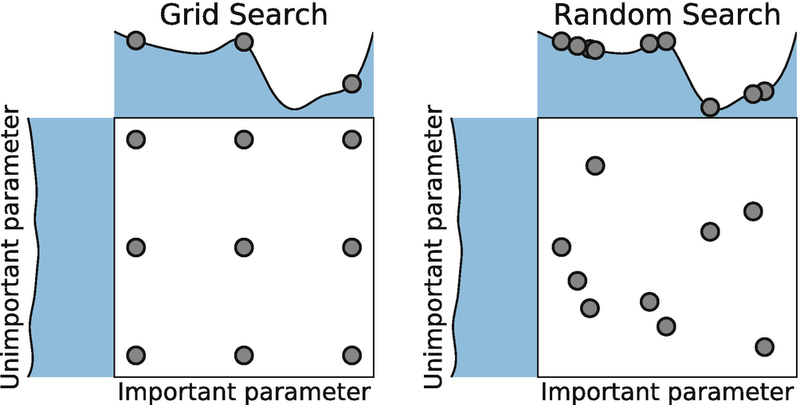

> 그림설명 : [Bergstra, J., Bengio, Y.: Random search for hyper-parameter optimization. Journal of Machine Learning Research 13, 281–305 (2012), 다음의 블로그에서 재인용]

우리는 앞서 언급했듯 다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 `GridSearchCV`를 활용해 볼 것입니다.

먼저 `GridSearchCV`에 입력되는 인자들은 다음과 같습니다.

- `param_grid` : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- `scoring` : 모델의 성능을 평가할 지표
- `cv` : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- `verbose` : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- `n_jobs` : 그리드 탐색을 진행하면서 사용할 CPU의 개수

그러면 param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비하겠습니다.

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

그다음으로 모델을 준비합니다. 모델은 LightGBM(lgbm)를 사용해봅시다.

In [ ]:
model = LGBMRegressor(random_state=random_state)

그러면 `model`, `param_grid`와 함께 다른 여러 가지 인자를 넣어서 `GridSearchCV`를 수행할 수 있습니다!

다음과 같이 `GridSearchCV`를 이용해서 `grid_model` 모델을 초기화하고, `train`과 `y` 데이터로 모델을 간단히 학습시키면 `param_grid` 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

이제 `grid_model.fit` 함수를 통해서 4가지 조합에 대한 실험을 모두 마쳤습니다.

실험에 대한 결과는 다음과 같이 `grid_model.cv_results_` 안에 저장됩니다.

In [ ]:
grid_model.cv_results_

정보가 너무 많아서 눈에 잘 들어오지 않으니 원하는 값만 정제해서 확인하도록 하겠습니다.

우리가 관심 있는 정보는 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이겠죠.
파라미터 조합은 위 딕셔너리 중 `params`에, 각각에 대한 테스트 점수는 `mean_test_score`에 저장되어 있습니다.

이 두 정보만 빼내어 보겠습니다.

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

**데이터 프레임 합쳐서 표현해 보기**

`params`에는 각 파라미터의 조합이, `score`에는 각 조합에 대한 점수가 들어가 있군요.

이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

다음과 같은 형태의 데이터 프레임을 출력하는 코드를 작성해 보겠습니다.


In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

자, 그런데 여기에서 한 가지 의문이 드는 것이 있습니다. 왜 점수는 음수일까요?!

그 이유는 바로 GridSearchCV을 초기화 한 코드에 힌트가 있습니다.
우리가 위에서 GridSearchCV로 grid_model 모델을 초기화할 때, scoring 인자에 무엇을 넣었는지 기억하시나요?

`GridSearchCV`를 사용할 때에는 이 외에도 다양한 점수 체계(scoring)를 사용할 수 있습니다. 그에 대한 정보는 다음 페이지에서 확인하겠습니다.

- [사이킷런 - The scoring parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

우리는 현재 Regression 문제를 풀고 있기 때문에 그에 알맞은 성능 평가 지표를 사용하였습니다.
우리가 사용한 것이 `neg_mean_squared_error`를 사용했기 때문에 점수가 음수로 표현되는 것이죠!

아래와 같은 간단한 변환 함수로 RMSE 점수를 볼 수 있도록 하겠습니다.
음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산을 해주면 되겠죠.

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

앗, 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 `price`에 있습니다. 위에서 우리는 `price`의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 rmse 값을 계산하기 위한 함수에서는 `np.expm1` 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 `np.expm1()`으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 `price` 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

**RMSE 컬럼명 바꾸기**

`RMSE` 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 [rename](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)으로 할 수 있습니다. 아래에 코드를 작성하고 출력해보세요.

In [ ]:
# 미션 : RMSE 컬럼명을 바꿔보세요.

##############################################
#### 코드리뷰 1-1. 알맞은 코드를 직접 작성해보세요! ####
##############################################

results = ... # '...'에 코드작성
results

이제 마지막 할 일은 RMSLE가 낮은 순서대로 정렬하는 것뿐이군요!

**RMSLE를 낮은 순서대로 정렬하기**
sort_values로 간단히 할 수 있습니다. 공식 문서를 참고해 직접 작성해 보세요.

In [ ]:
# 미션 : results 데이터 프레임에서 RMSLE가 낮은 순으로 정렬해보세요.

##############################################
#### 코드리뷰 1-2. 알맞은 코드를 직접 작성해보세요! ####
##############################################

results = ... # '...' 에 코드 작성
results

### [TODO] 4_ 정리하기

지금까지의 `GridSearchCV`를 통해 진행한 내용들을 간단히 함수로 만들어 보도록 하겠습니다.

다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.

In [ ]:
## 미션 : GridSearchCV 를 통해 진행한 내용을 함수로 만들어보세요.

##############################################
#### 코드리뷰 1-3. 알맞은 코드를 직접 작성해보세요! ####
##############################################

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = ... # '...' 에 코드 작성
    score = ... # '...' 에 코드 작성

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = ... # '...'에 코드 작성

    # RMSLE 값 계산
    results['RMSLE'] = ... # '...'에 코드작성

    # RMSLE 값으로 정렬
    results = ...
    results = ... # '...'에 코드작성

    return results

## 2. 대회 참여하기
- 예측 결과를 대회에 제출하고, Public Score를 확인합니다.

이제 실험에 대한 준비는 모두 끝났습니다! 실험을 통해 좋은 결과를 내는 모델을 찾았다면 제출을 해봐야겠죠. 제출 과정 또한 하나의 함수로 깔끔하게 진행하겠습니다.

먼저 여러분이 만들어놓은 `my_GridSearch()` 함수로 간단한 그리드 탐색을 해보겠습니다.

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

가장 좋은 조합은 `max_depth=10`, `n_estimators=100` 이군요.
해당 모델로 학습을 해서 예측값인 `submission.csv` 파일을 만들어서 제출해보겠습니다.

먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

앗, 예측 결과에 `np.expm1()`을 씌워서 다시 원래 스케일로 되돌리는 것도 잊으면 안 되겠죠!

In [ ]:
prediction = np.expm1(prediction)
prediction

샘플로 제공받은 `sample_submission.csv` 파일을 로드해보겠습니다. 거기에 덮어씌우면 되기 때문입니다.

In [ ]:
submission_path = './data/sample_submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우겠습니다.

In [ ]:
submission['price'] = prediction
submission.head()

위의 데이터를 csv 파일로 저장하겠습니다.

단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('./data', 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

위의 과정들도 하나의 함수로 정리해두면 사용하기 편리하겠죠.

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

이 함수를 사용한다면 다음 한 줄로 모델을 학습시킨 후 예측 결과를 저장할 수 있습니다.

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

### [TODO] 5_ 제출결과 확인하기

여러분이 제출한 Public Score는 몇점이신가요? 이 대회는 지난 대회이기 때문에 여러분의 결과가 Leaderboard에 등록되지 않습니다. 그러나 여러분의 결과가 어느정도 순위인지 Leaderboard를 통해서 직접 확인해 보실 수는 있습니다.

In [ ]:
# 미션 : 아래에 Public Score를 기록하여 제출해보세요.

print(...)

## 3. 코드리뷰 프로젝트 제출하기

- 수행한 프로젝트 내용을 확인하고, 전체 코드를 파이썬 파일(.py)로 저장합니다.
- 다운로드 받은 .py 파일을 zip으로 압축 및 제출하여 수행여부를 증빙합니다.
- 이번 차시에 궁금한 점이 있다면, 본문에 내용을 함께 작성하여 제출할 수 있습니다.

ALL RIGHTS RESERVED. (C)NAVER Connect Foundation.